<a href="https://colab.research.google.com/github/jt-ut/GaiaREU/blob/main/GaiaREU-ML_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Welcome to a Machine Learning Workshop for Astronomy!


---

July 10, 2023  
Hosts:  
Josh Taylor, Postdoctoral Fellow  
Stella Offner, Associate Professor  
The University of Texas at Austin, Department of Astronomy


---


## Workshop Goals

Today we will show you how modern Machine Learning techniques can be used in Python to address common questions we have about (or ask of) data during the analysis stage of research projects. We will cover:
1. **Exploratory Data Analysis**, which is the process of quickly getting a high-level view of your data.
2. **Clustering**, which is a methodical way of partitioning a dataset into meaningful subgroups for further analysis.
3. **Classification**, which incorporates auxiliary information about our data in order to make predictions from it.

The first two tasks are examples of **Unsupervised Machine Learning**, which is the branch of ML concerned with making inferences about data *using only the data at hand*. The last is an example of **Supervised Machine Learning**, as it relies on auxiliary information (i.e., a "supervisor") to guide its inferences.


## Example Data: Gaia Spectroscopy

We have selected a real astronomy dataset to help showcase our ML techniques. These data come from the [Gaia Space Mission](https://www.esa.int/Science_Exploration/Space_Science/Gaia_overview), which is an ongoing in-depth survey of ~1 billion objects in the Milky Way. The [Gaia Data Archive](https://gea.esac.esa.int/archive/) housed by the European Space Agency contains many different types of observations made of Gaia's targets.

Today we will work with spectroscopy measurements of a small subset of Gaia targets. Our data are 343 flux measurements across a range of red & blue wavelengths for 3,388 different sources. We curated this subset from a much larger set of spectral data found [here](http://cdn.gea.esac.esa.int/Gaia/gdr3/Spectroscopy/xp_sampled_mean_spectrum/). We have normalized our data such that each source's spectra has unit Euclidean norm when considered as a vector.

Before we get started exploring Gaia, we need to ensure all Python packages needed for further analysis are available. Run the following block, and ask us for help if any of the installation steps do not complete successfully.

In [1]:
## Install additional Python packages
!pip install umap-learn yellowbrick

## Import required modules
## These are pre-installed in Google Colab's engine
# For data wrangling
import pandas as pd
import numpy as np
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
# Dimensionality Reduction & Testing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
from umap import UMAP
# Clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# Classification
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, balanced_accuracy_score


# Set some default plotting parameters
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=ccdad7b64fff6b87b3a2e7914872055b24111fa55ecb7f875e47f520a1835163
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=5a694e35339c25cee10543cef6aea97b0e00acd6dda228168f9bbab8325a92df
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


# Exploratory Gaia Analysis with Unsupervised Machine Learning

With Python setup complete, let's fetch our sample from its web source and do a quick inspection of its size & contents.

In [45]:
# Read data from web
flux = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/GaiaREU_flux_trn.csv', header=None)
wvl = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/GaiaREU_wvl-nanometer.csv', header=None)[0]
flux.columns = wvl

# Inspect the downloaded data
print(flux.shape)
print(flux.iloc[0])

print(wvl.shape)
print(wvl)

(3388, 343)
0
330.000000     0.027306
332.105263     0.022852
334.210526     0.020077
336.315789     0.019672
338.421053     0.018942
                 ...   
1041.578947    0.045485
1043.684211    0.045064
1045.789474    0.046384
1047.894737    0.046835
1050.000000    0.049180
Name: 0, Length: 343, dtype: float64
(343,)
0       330.000000
1       332.105263
2       334.210526
3       336.315789
4       338.421053
          ...     
338    1041.578947
339    1043.684211
340    1045.789474
341    1047.894737
342    1050.000000
Name: 0, Length: 343, dtype: float64


Our flux data is arranged into a 3,388 row $\times$ 343 column ***data matrix***.

Each row represents an individual source (emitter of light) in the Gaia archive, and each column holds the flux measurements of that source at the 343 different wavelengths stored in the `wvl` vector, spanning the [330,1050] nanometer range. Our data is actually flux from a model fit (not the actual observation). You can read more about Gaia spectra processing [here](https://www.aanda.org/articles/aa/pdf/2023/06/aa43709-22.pdf).  

Almost all statistical and machine learning software packages expect a data matrix arranged as above, with ***observations*** contained in its rows and ***variable measurements*** in its columns.

Let's plot some of our spectra just to get an idea of what these 343-dimensional vectors can look like.

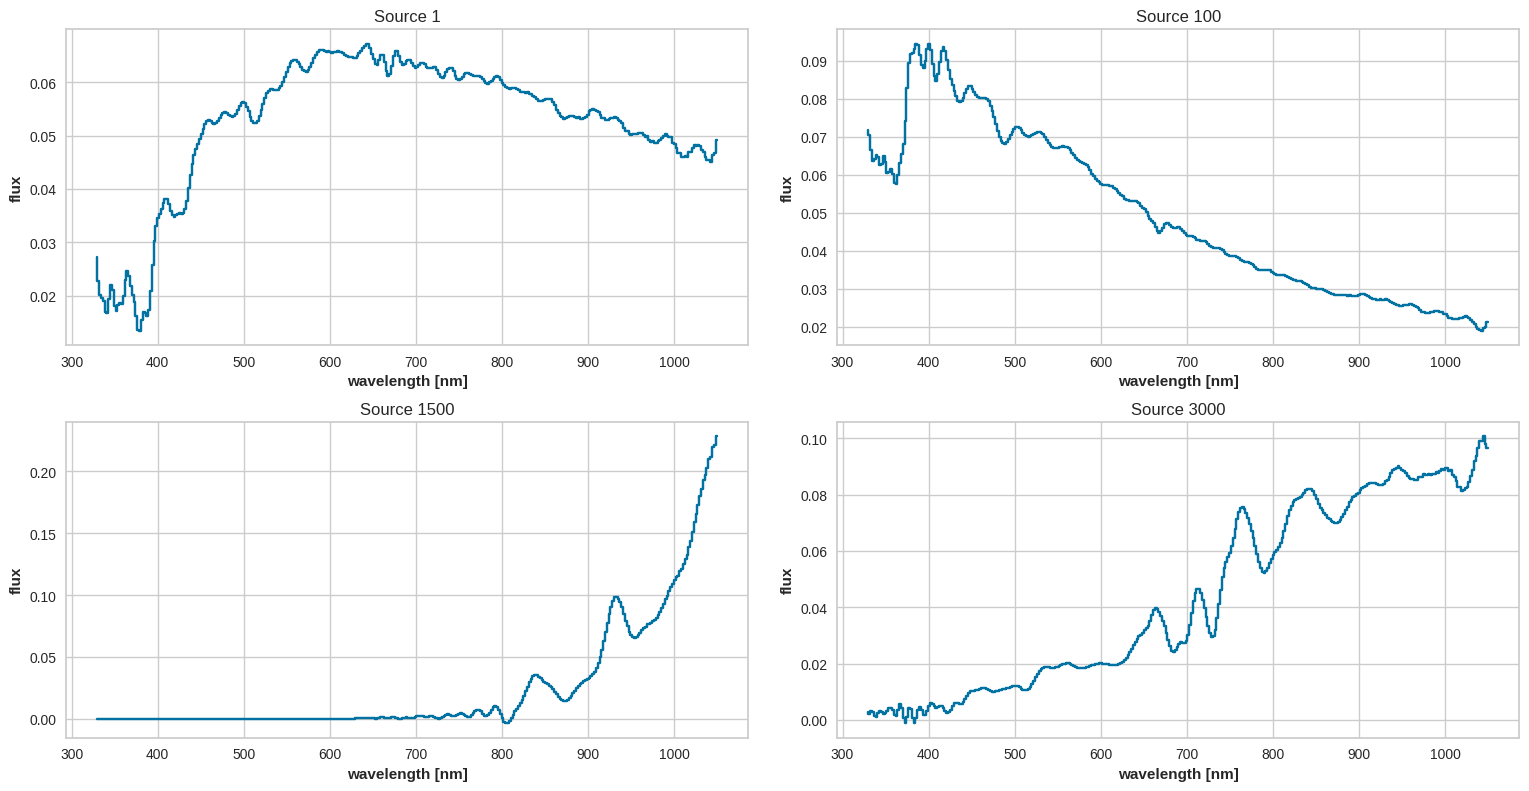

In [51]:
# Plot a few spectra
plt.rcParams['figure.figsize'] = (10,5)
fig, axes = plt.subplots(2, 2)
fig.tight_layout()
sns.lineplot(x = 'wavelength [nm]', y = 'flux', data = pd.DataFrame({'wavelength [nm]': flux.columns, 'flux': flux.iloc[0]}), drawstyle='steps-pre', ax=axes[0,0]).set(title='Source 1')
sns.lineplot(x = 'wavelength [nm]', y = 'flux', data = pd.DataFrame({'wavelength [nm]': flux.columns, 'flux': flux.iloc[99]}), drawstyle='steps-pre', ax=axes[0,1]).set(title='Source 100')
sns.lineplot(x = 'wavelength [nm]', y = 'flux', data = pd.DataFrame({'wavelength [nm]': flux.columns, 'flux': flux.iloc[1499]}), drawstyle='steps-pre', ax=axes[1,0]).set(title='Source 1500')
sns.lineplot(x = 'wavelength [nm]', y = 'flux', data = pd.DataFrame({'wavelength [nm]': flux.columns, 'flux': flux.iloc[2999]}), drawstyle='steps-pre', ax=axes[1,1]).set(title='Source 3000')
fig.subplots_adjust(top=1.5, right=1.5);
plt.show()

What we have just done, plotting actual data vectors in their native space, is called ***data visualiation***. Visualizing your data is probably the easiest, and most intuitive, part of ***exploratory data analysis***, which allows us to get a crude idea of what's "going on" in our data. For example, our plots above indicate that the sources in our sample can have drastically different spectral profiles.


##Dimensionality Reduction

Since we can't realistically visualize the 343-dim spectra of all 3,000+ sources in our sample, we will instead build a *representation* of our data and visualize that. **Dimensionality Reduction** is the process of representing high-dimensional data in a lower dimensional space, usually 2-d or 3-d, for easy visualization. This is also called ***embedding*** our data into a lower dimensional space.

There are many DR algorithms in statistics and machine learning. We introduce a few of the most commonly used below:

### PCA

Principal Components Analysis is an older technique from statistics that represents data as a linear combination of the eigenvectors of its covariance (corelation) matrix. DR is achieved by projecting data onto just a few (2 or 3) of these eigenvectors. While the more modern DR methods we discuss next are usually more expressive than PCA, it remains a common tool for data reduction because 1) there are no parameters for the user to worry about, 2) there are mathematical proofs of its optimality for variance explanation (no other DR technique has proofs of this nature) and 3) as a linear transformation of our data, it is very fast.


### t-SNE

t-distributed Stochastic Neighbor Embedding ([t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)) attempts to place points in low-dimensional space such that similarities among their $k$-nearest high-dimensional neighbors are preserved. $k$ is a user-supplied parameter that t-SNE calls *perplexity*. t-SNE defines point-wise similarity as a (Gaussian) function of distance, and minimizes [Kullback-Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) to bring low-dim point similarites in line with their high-dim counterparts.

### UMAP

Uniform Manifold Approximation & Projection ([UMAP](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)) is built upon the same idea as t-SNE, except it defines its high-dim and low-dim similarities differently (but still as a function of distance), and then attempts to find low-dim points which minimize the [Cross-Entropy](https://en.wikipedia.org/wiki/Cross_entropy) between themselves and their high-dim counterparts. UMAP also needs a user-supplied parameter it calls *n_neighbors*, which controls how many point-wise similarities should be preserved in low-dim.

For now, don't worry about the details of how t-SNE and UMAP work. Just remember that both try to embed points such that their low-dim proximity represents their high-dim similarity.  

Let's perform Dimensionality Reduction on our data and see how each of the above algorithms places points in the plane.

In [10]:
## PCA, no parameters needed!
X_pca = PCA(n_components=2).fit_transform(flux)
X_pca = pd.DataFrame(X_pca, columns = ['x','y'])

## t-SNE, using default perplexity = 30
X_tsne = TSNE(perplexity=30.0, n_components=2, random_state = 123, verbose=1, n_jobs=2).fit_transform(flux)
X_tsne = pd.DataFrame(X_tsne, columns = ['x','y'])

## UMAP, using its default n_neighbors = 15
X_umap = UMAP(n_neighbors=15, n_components=2, n_jobs = 2, random_state=123, verbose=True).fit_transform(flux)
X_umap = pd.DataFrame(X_umap, columns = ['x','y'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3388 samples in 0.010s...
[t-SNE] Computed neighbors for 3388 samples in 0.500s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3388
[t-SNE] Computed conditional probabilities for sample 2000 / 3388
[t-SNE] Computed conditional probabilities for sample 3000 / 3388
[t-SNE] Computed conditional probabilities for sample 3388 / 3388
[t-SNE] Mean sigma: 0.023655
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.731930
[t-SNE] KL divergence after 1000 iterations: 0.722527
UMAP(n_jobs=2, random_state=123, verbose=True)
Mon Jul 10 11:20:36 2023 Construct fuzzy simplicial set
Mon Jul 10 11:20:45 2023 Finding Nearest Neighbors
Mon Jul 10 11:20:49 2023 Finished Nearest Neighbor Search
Mon Jul 10 11:20:52 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jul 10 11:21:01 2023 Finished embedding


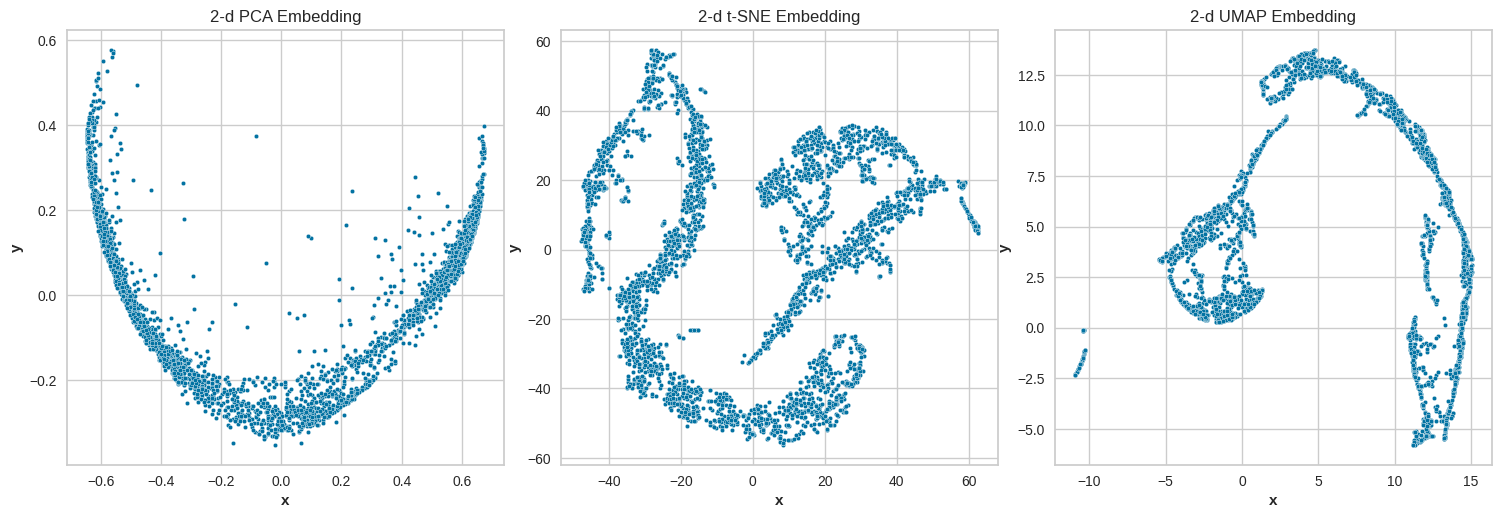

In [11]:
## Visualize the PCA, t-SNE, and UMAP representations of our spectra
plt.rcParams['figure.figsize'] = (15,5)

fig, axes = plt.subplots(1, 3)
fig.tight_layout()
sns.scatterplot(x='x', y='y', data = X_pca, s=10, ax=axes[0]).set(title='2-d PCA Embedding')
sns.scatterplot(x='x', y='y', data = X_tsne, s=10, ax=axes[1]).set(title='2-d t-SNE Embedding')
sns.scatterplot(x='x', y='y', data = X_umap, s=10, ax=axes[2]).set(title='2-d UMAP Embedding')
plt.show()

> **Based on these representations, does our data appear to be completely random, or does it have any meaningful structure?**

> **Based on how PCA, t-SNE, and UMAP work, what do you think any 2-d structure visible in the above might suggest about our 343-d flux data?**

## Kernel Smoothing

It is usually hard, and generally a bad idea, to draw conclusions about your data by scrutinizing individual points.  This is because almost all real-world datasets contain ***noise***, and when you pick a few points at random from your sample you cannot be reasonably certain whether they are, or are not, noise.

The field of statistics offers many tools to help us "see" signals despite the presence of noise. One of these is called ***kernel smoothing***, or ***kernel density estimation***. The idea is to build a smoothed representation of the ***data density*** (number of points in a fixed area / volume) from which we can draw conclusions about our data.

Let's see how smoothed version of our embeddings look.

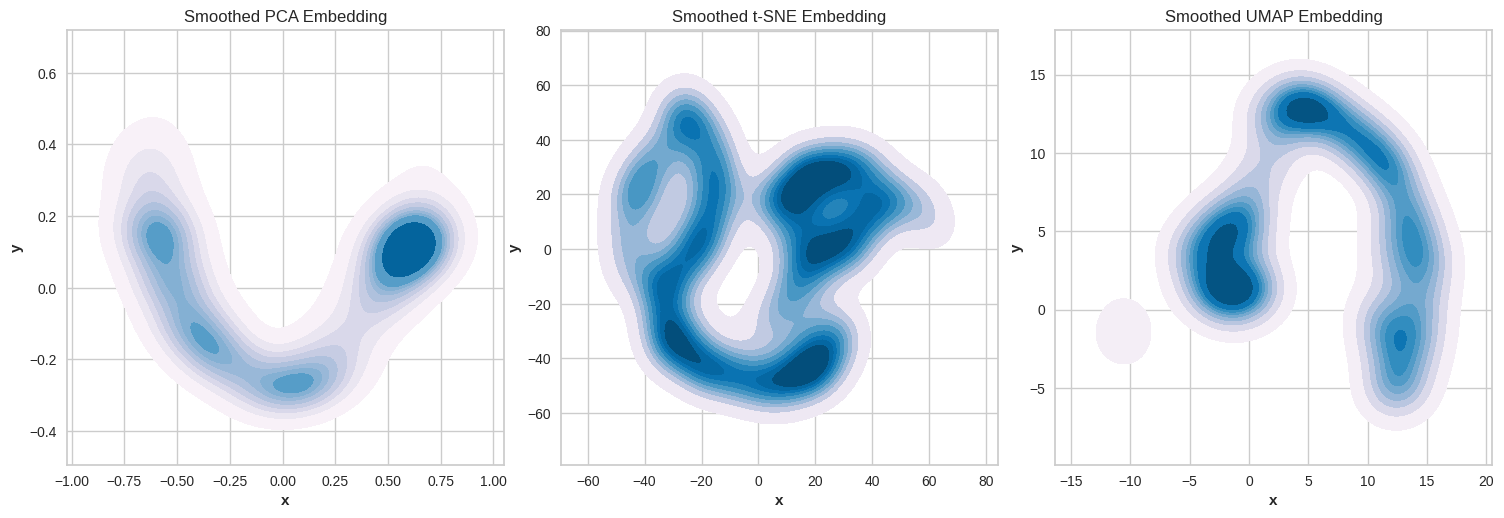

In [12]:
## Smoothed visualizations of our embedded data
plt.rcParams['figure.figsize'] = (15,5)
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
sns.kdeplot(data=X_pca, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[0]).set(title='Smoothed PCA Embedding')
sns.kdeplot(data=X_tsne, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[1]).set(title='Smoothed t-SNE Embedding')
sns.kdeplot(data=X_umap, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[2]).set(title='Smoothed UMAP Embedding')
plt.show()

Darker colors in the above heatmaps represent areas of higher data density, meaning points are packed more tightly in these regions.

> **Do you see more structure than in the scatterplots we made above? Is it easier to see?**

## DR Parameterization

Recall that both t-SNE and UMAP have a parameter controlling how many high-dim neighbors they attempt to preserve in low-dim. t-SNE calls this *perplexity*, which we left at its default = 30, and UMAP calls this *n_neighbors*, which we left at its default = 15.

Let's change these parameters, setting them both lower and higher than their default, to see how this affects the representation of our flux data.

In [13]:
## Supply a t-SNE perplexity < 30, and a UMAP n_neighbors < 15
lo_perplexity = 10
lo_n_neighbors = 5
# Supply a perplexity > 30, and a n_neighbors > 15
hi_perplexity = 50
hi_n_neighbors = 25

## Re-run both t-SNE & UMAP at the low and high parameter values
X_tsne_lo = TSNE(perplexity=lo_perplexity, n_components=2, random_state = 123, verbose=1, n_jobs=2).fit_transform(flux)
X_tsne_lo = pd.DataFrame(X_tsne_lo, columns = ['x','y'])

X_umap_lo = UMAP(n_neighbors=lo_n_neighbors, n_components=2, n_jobs = 2, random_state=123, verbose=True).fit_transform(flux)
X_umap_lo = pd.DataFrame(X_umap_lo, columns = ['x','y'])

X_tsne_hi = TSNE(perplexity=hi_perplexity, n_components=2, random_state = 123, verbose=1, n_jobs=2).fit_transform(flux)
X_tsne_hi = pd.DataFrame(X_tsne_hi, columns = ['x','y'])

X_umap_hi = UMAP(n_neighbors=hi_n_neighbors, n_components=2, n_jobs = 2, random_state=123, verbose=True).fit_transform(flux)
X_umap_hi = pd.DataFrame(X_umap_hi, columns = ['x','y'])

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3388 samples in 0.006s...
[t-SNE] Computed neighbors for 3388 samples in 0.355s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3388
[t-SNE] Computed conditional probabilities for sample 2000 / 3388
[t-SNE] Computed conditional probabilities for sample 3000 / 3388
[t-SNE] Computed conditional probabilities for sample 3388 / 3388
[t-SNE] Mean sigma: 0.016104
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.025269
[t-SNE] KL divergence after 1000 iterations: 0.981080
UMAP(n_jobs=2, n_neighbors=5, random_state=123, verbose=True)
Mon Jul 10 11:22:37 2023 Construct fuzzy simplicial set
Mon Jul 10 11:22:45 2023 Finding Nearest Neighbors
Mon Jul 10 11:22:45 2023 Finished Nearest Neighbor Search
Mon Jul 10 11:22:45 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jul 10 11:22:51 2023 Finished embedding
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3388 samples in 0.005s...
[t-SNE] Computed neighbors for 3388 samples in 0.449s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3388
[t-SNE] Computed conditional probabilities for sample 2000 / 3388
[t-SNE] Computed conditional probabilities for sample 3000 / 3388
[t-SNE] Computed conditional probabilities for sample 3388 / 3388
[t-SNE] Mean sigma: 0.028783
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.369186
[t-SNE] KL divergence after 1000 iterations: 0.590640
UMAP(n_jobs=2, n_neighbors=25, random_state=123, verbose=True)
Mon Jul 10 11:23:20 2023 Construct fuzzy simplicial set
Mon Jul 10 11:23:29 2023 Finding Nearest Neighbors
Mon Jul 10 11:23:30 2023 Finished Nearest Neighbor Search
Mon Jul 10 11:23:30 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jul 10 11:23:39 2023 Finished embedding


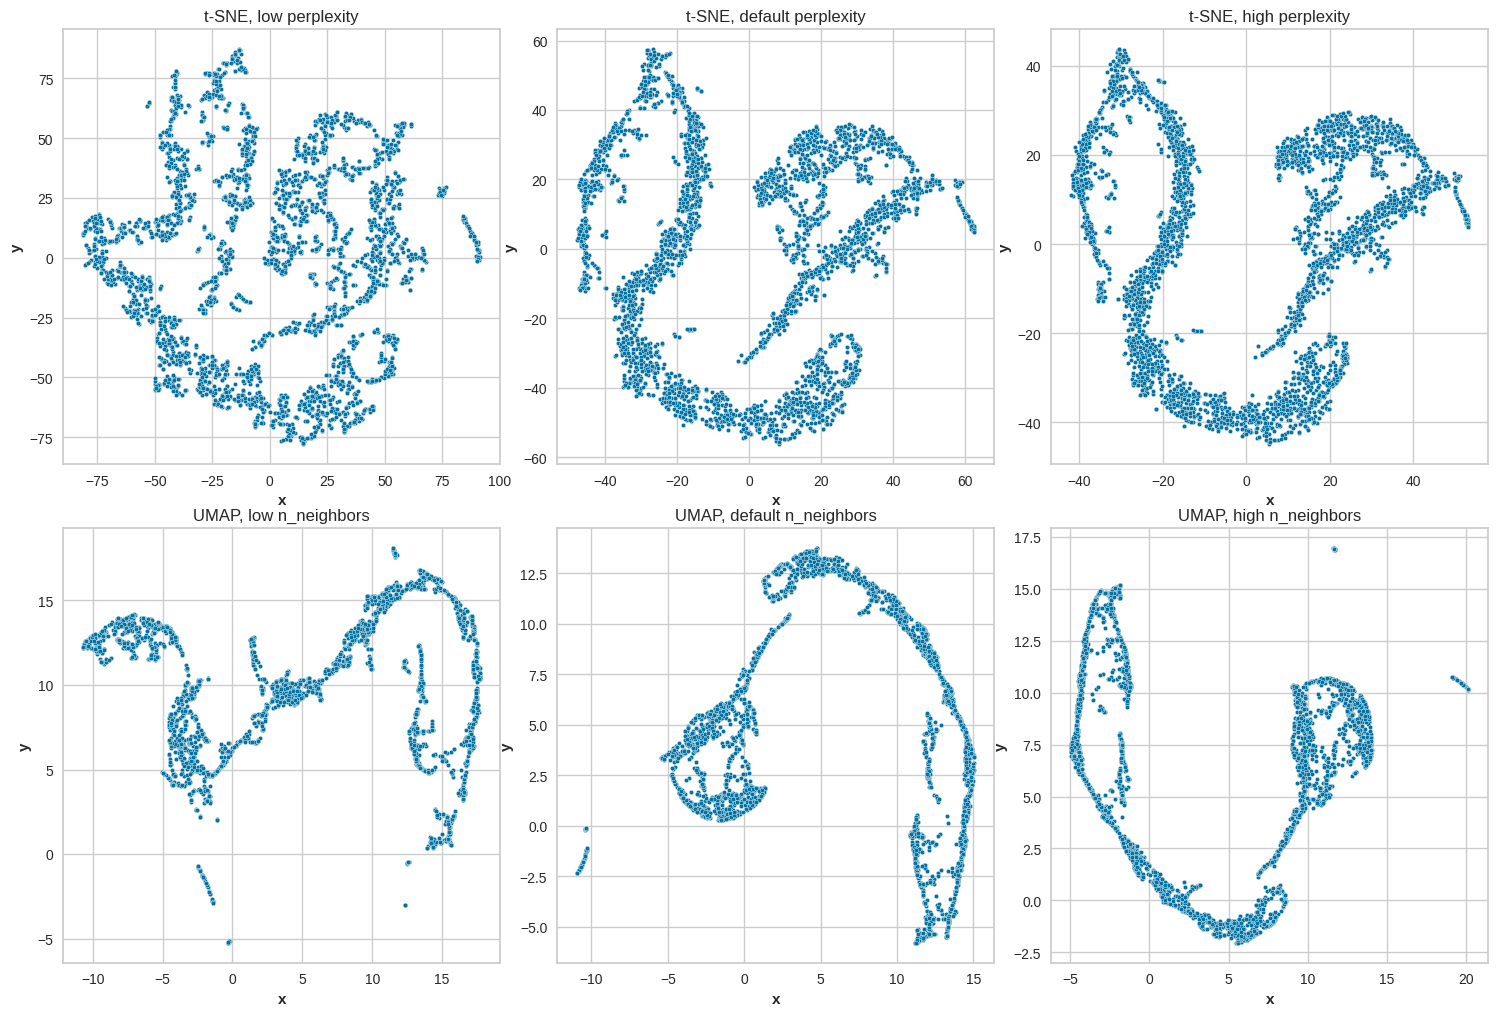

In [18]:
## Visualize the original embeddings along with their lo/hi parameterized counterparts
plt.rcParams['figure.figsize'] = (15,7.5)
fig, axes = plt.subplots(2, 3)
fig.tight_layout()
fig.subplots_adjust(top=1.3);
sns.scatterplot(x='x', y='y', data = X_tsne_lo, s=10, ax=axes[0][0]).set(title='t-SNE, low perplexity')
sns.scatterplot(x='x', y='y', data = X_tsne, s=10, ax=axes[0][1]).set(title='t-SNE, default perplexity')
sns.scatterplot(x='x', y='y', data = X_tsne_hi, s=10, ax=axes[0][2]).set(title='t-SNE, high perplexity')
sns.scatterplot(x='x', y='y', data = X_umap_lo, s=10, ax=axes[1][0]).set(title='UMAP, low n_neighbors')
sns.scatterplot(x='x', y='y', data = X_umap, s=10, ax=axes[1][1]).set(title='UMAP, default n_neighbors')
sns.scatterplot(x='x', y='y', data = X_umap_hi, s=10, ax=axes[1][2]).set(title='UMAP, high n_neighbors')
plt.show()

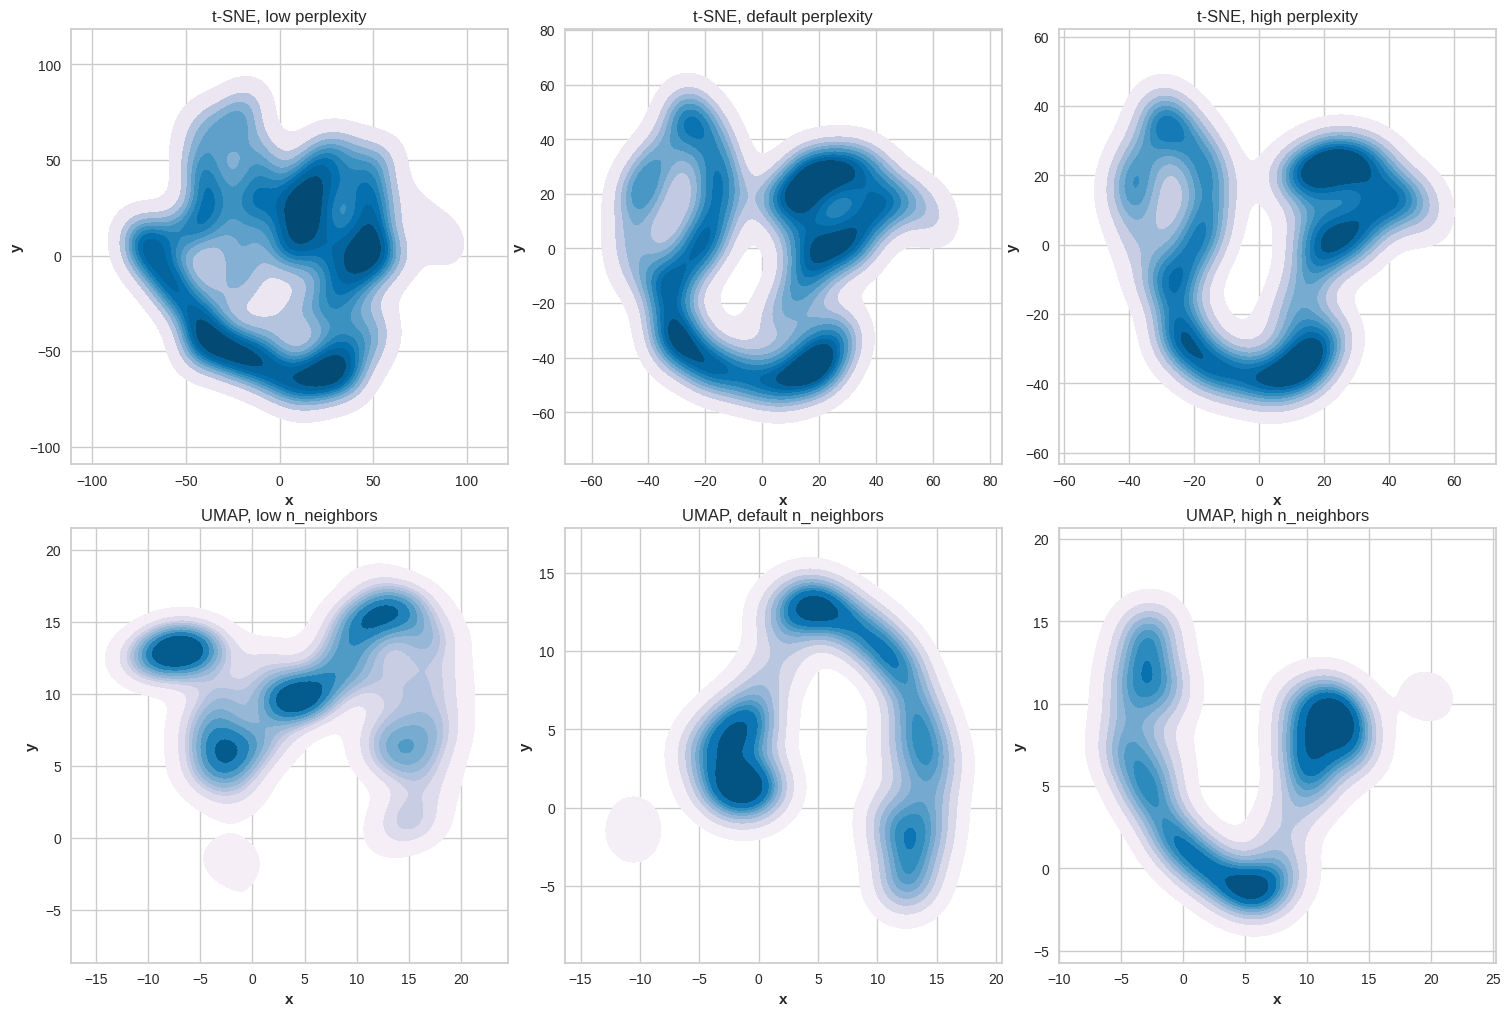

In [19]:
## Smoothed versions of the above
plt.rcParams['figure.figsize'] = (15,7.5)
fig, axes = plt.subplots(2, 3)
fig.tight_layout()
fig.subplots_adjust(top=1.3);
sns.kdeplot(data=X_tsne_lo, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[0][0]).set(title='t-SNE, low perplexity')
sns.kdeplot(data=X_tsne, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[0][1]).set(title='t-SNE, default perplexity')
sns.kdeplot(data=X_tsne_hi, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[0][2]).set(title='t-SNE, high perplexity')
sns.kdeplot(data=X_umap_lo, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[1][0]).set(title='UMAP, low n_neighbors')
sns.kdeplot(data=X_umap, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[1][1]).set(title='UMAP, default n_neighbors')
sns.kdeplot(data=X_umap_hi, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[1][2]).set(title='UMAP, high n_neighbors')
plt.show()

> **Does your assessment of how much structure is our data change with different parameterizations? If so, how?**

## Assessing the Quality of DR Embeddings

The process of choosing the "best" among many competing Machine Learning models is called ***model selection***. How do we perform model selection for Dimensionality Reduction?

The authors of both t-SNE and UMAP recommend running their algorithms over a range of parameterizations and selecting the best model from this set. Sadly, their recommendations are silent on how to pick the best among these many candidate embeddings, because what is "best" changes with every dataset you will encounter.

**This is a frustrating circular issue in all Unsupervised Machine Learning. In order to assess how good your learning is, you must first know what you're trying to learn.**

One way of breaking this circular problem is to ask how well our algorithms performed, relative to what they were *trying* to achieve. For t-SNE and UMAP, that means comparing high-dim neighborhoods to their low-dim counterparts.

scikit-learn has a built-in [trustworthiness](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.trustworthiness.html) function that does this, which reports the proportion of high-d $k$-nearest neighborhoods which are preserved in a low-d embedding. Thus, a trustworthiness value is in the range $[0,1]$, with 0 meaning NONE of the neighbor relationsips are preserved (bad), and 1 meaning ALL neighbor relationships are preserved (good).

Since we don't know the "right" $k$ (neighborhood size) to consider here, we will compute the trustworthiness over values in the range of $k$ we specified above, and see how each method performs overall.

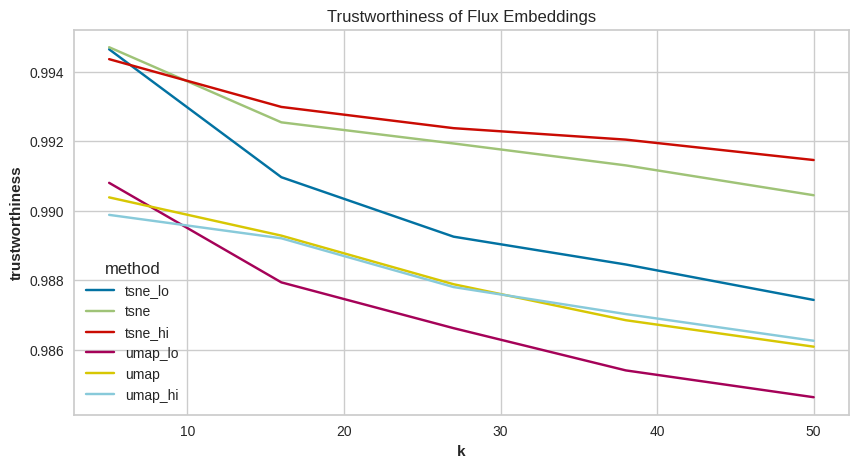

In [20]:
## Define a grid of evenly spaced k values at which to measure trustworthiness
#  We use a grid here vs. computing the metric at every k to save time
k_grid = np.linspace(start=min(lo_perplexity, lo_n_neighbors), stop=max(hi_perplexity, hi_n_neighbors), num = 5).astype('int')

# Compute trustworthiness for each method, at each value of k in our range
trust = pd.DataFrame(columns = ['method','k','trustworthiness'])
for k in k_grid:
  trust.loc[len(trust)] = ['tsne_lo', k, trustworthiness(X=flux, X_embedded=X_tsne_lo, n_neighbors=k, metric='euclidean')]
  trust.loc[len(trust)] = ['tsne', k, trustworthiness(X=flux, X_embedded=X_tsne, n_neighbors=k, metric='euclidean')]
  trust.loc[len(trust)] = ['tsne_hi', k, trustworthiness(X=flux, X_embedded=X_tsne_hi, n_neighbors=k, metric='euclidean')]
  trust.loc[len(trust)] = ['umap_lo', k, trustworthiness(X=flux, X_embedded=X_umap_lo, n_neighbors=k, metric='euclidean')]
  trust.loc[len(trust)] = ['umap', k, trustworthiness(X=flux, X_embedded=X_umap, n_neighbors=k, metric='euclidean')]
  trust.loc[len(trust)] = ['umap_hi', k, trustworthiness(X=flux, X_embedded=X_umap_hi, n_neighbors=k, metric='euclidean')]

# Plot results
plt.rcParams['figure.figsize'] = (10,5)
sns.lineplot(x='k', y='trustworthiness', data=trust, hue='method').set(title='Trustworthiness of Flux Embeddings');

> **Which method appears to represents most $k$-nearest neighborhoods best?**

Let's save the $(x,y)$ values of your favorite embedding in the new data frame **X_best**:

In [21]:
## Uncomment the line corresponding to your favorite embedding, and run this cell.
## Later, we will use your favorite embedding to visualize more information learned from Gaia

#X_best = X_tsne_lo
#X_best = X_tsne
X_best = X_tsne_hi
#X_best = X_umap_lo
#X_best = X_umap
#X_best = X_umap_hi

# Clustering

The most common technique in Unsupervised Machine Learning is called [clustering](https://en.wikipedia.org/wiki/Cluster_analysis), which partitions a dataset into $K$ groups of "similar items." This is a more formal process that mimics the visual search for structure we attempted above.

As you might suspect, there is no universally applicable definition of what it means for two points to be "similar". Because each clustering algorithm differs in how they define point-wise similarities, there is also (sadly) no universally "best" clustering algorithm. Just like in DR analysis, we usually have to try several different algorithms with different parameterizations, and use external knowledge or assumptions about the domain which generated our data (here, astronomy) to pick a good clustering.  

## K-Means

Although there are [many](https://scikit-learn.org/stable/modules/clustering.html) algorithms to choose from, we will partition Gaia using  [K-Means](https://en.wikipedia.org/wiki/K-means_clustering#:~:text=k%2Dmeans%20clustering%20is%20a,a%20prototype%20of%20the%20cluster.), which is one of the oldest and simplest clustering methods. Despite its age and simplicity, K-Means is still widely used in practice, partly because we understand everything about it and partly because it's fast.  

K-Means only has one parameter, $K$, which tells the algorithm how many groups to find in the data. Once you supply $K$, the algorithm returns to you $K$ group centroids (means) which are closest to most of the data. All data that are closer to centroid $i$ than any other centroid are assigned to group (or cluster) $i$, etc.

To get a feel for how this works, let's ask K-Means to partition our data into 5 groups, and see how those groups are displayed on the embedding you selected above.  

The colors on the resulting plot correspond to each points's cluster label.

[Text(0.5, 1.0, 'K-Means Clustering, K=5')]

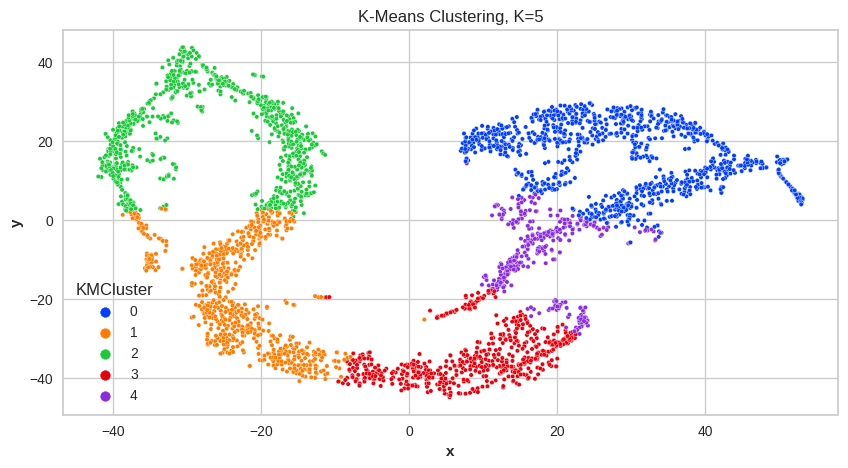

In [22]:
## Run K-Means Clustering with K=5 groups
#  Calling KMeans returns an integer vector, length = nrows(flux),
#  which contains the cluster label for each Gaia source
X_best['KMCluster'] = KMeans(n_clusters=5, init='k-means++', n_init=1, random_state=123).fit(flux).labels_

plt.rcParams['figure.figsize'] = (10,5)
sns.scatterplot(x='x', y='y', hue='KMCluster', data = X_best, s=10, palette="bright").set(title='K-Means Clustering, K=5')

In the above, we *clustered* the data in high-d space, and visualized the results by *projecting* the cluster labels onto our low-dim embedding.

> **Do the clusters appear organized on the embedding?**

> **Does the partition found by K-Means appear to agree with the structure you see in the embedding?**

## Selecting the Number of K-Means Clusters

In the above we arbitrarily grouped Gaia point sources into 5 distinct clusters, just to see how K-Means works.  But the point of clustering is to separate our data into ***meaningful*** (not arbitrary) groups. This is a challenging task as we do not know how many meaningful groups may exist in our data. So how do we decide which $K$ to specify for K-Means? This is another form of ***model selection***.

The typical way of solving this problem is to run K-Means several times with different values of $K$ and measure the quality of the resulting clusters as reported by various ***clustering performance metrics***. There are [many](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) such metrics which are inspired by an intuitive notion of what a cluster is: good clusters are generally ***compact***, meaning the points within a cluster are close to each other, and ***well-separated***, meaning the individual clusters are far apart from each other.

We will run K-Means for different $K$ in the range $(2,20)$, and assess the resulting clusterings using three different metrics:
* Distortion (low distortion is better)
* Silhouette Score (high Silhouette is better)
* Calinski-Harabasz Score (high CH is better)

We *could* do this exercise manually using functions from scikit-learn, but there is a more automated way of producing & visualizing this information available in Python's yellowbrick package. Below, we produce plots of Distortion/Silhouette/CH score vs. $K$, and inspect the curves to find the $K$ which optimizes each score.

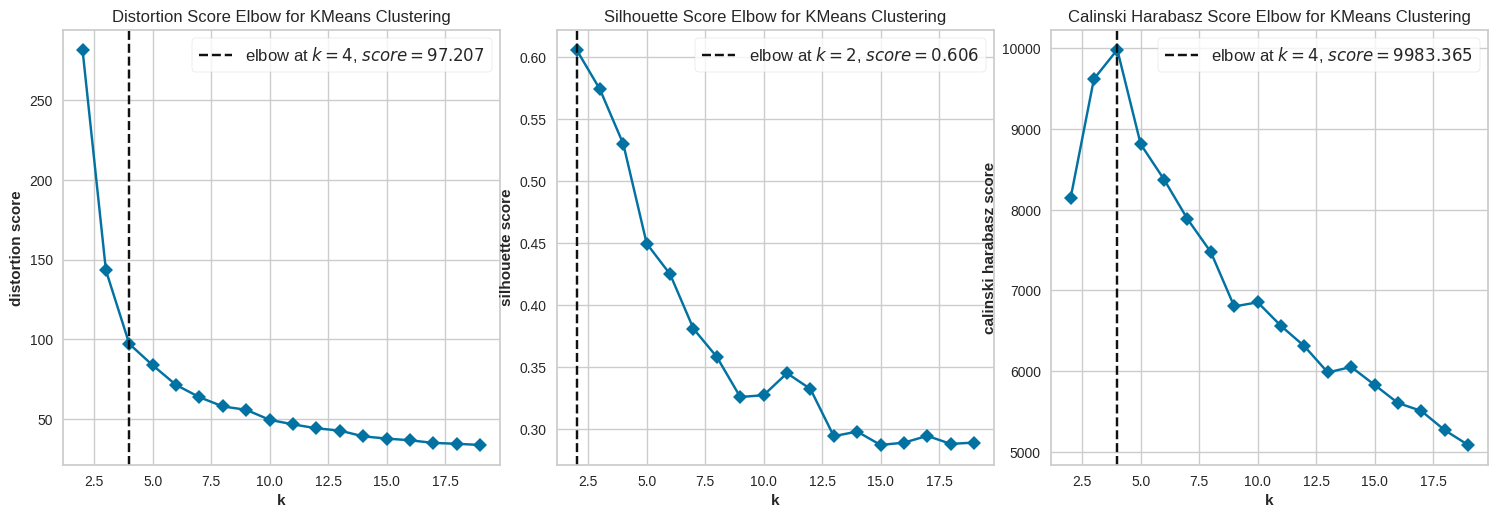

In [23]:
## K-Means Elbow Plots
# Setup K-Means as the cluster algorithm, specify the range of different K we will consider
model = KMeans(init='k-means++', n_init=1, random_state=123)
Krange = (2,20)
# Axes to plot different visualizations
plt.rcParams['figure.figsize'] = (15,5)
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
# Measure by distortion
kselect_dist = KElbowVisualizer(model, k=Krange, metric = 'distortion', timings=False, ax=axes[0])
kselect_dist.fit(flux) # Fit data to visualizer
kselect_dist.finalize()
# Measure by Silhouette
kselect_sil = KElbowVisualizer(model, k=Krange, metric = 'silhouette', timings=False, ax=axes[1])
kselect_sil.fit(flux) # Fit data to visualizer
kselect_sil.finalize()
# Measure by Calinski-Harabasz
kselect_ch = KElbowVisualizer(model, k=Krange, metric = 'calinski_harabasz', timings=False, ax=axes[2])
kselect_ch.fit(flux) # Fit data to visualizer
kselect_ch.finalize()

You should see that not all curves have a clearly defined optimal $K$.

* Recall that lower values of Distortion are preferred, and yet the Distortion curve monotonically decreases as $K$ increases. This is ***always true*** for K-Means, so instead of picking the $K$ with absolute minimal Distortion, we instead inspect the curve for points at which it stops changing dramatically. This is called the **knee** / **elbow** of the curve, and there are algorithms that try and locate it automatically (`KElbowVisualizer` does this internally).

* The Silhouette score is maximized at $K=2$. Based on the t-SNE and UMAP plots we made above, do you think there are only 2 clusters of data within Gaia? If you had to pick another "best" $K$ based on Silhouette (excluding $K=2$) which would you pick, and why?

* The CH score is maximized for $K=4$ and decreases monotonically thereafer. But again, examining the shape of the curve after $K=4$ indicates that some larger number of clusters may exist.

The above exercises highlights that, despite our best efforts, selecting the "right" number of clusters in a dataset is difficult, and there are often valid arguments to be made supporting *several* candidate $K$s.

Based on these plots, and what you can see in the t-SNE / UMAP embeddings we made, decide how many clusters you believe may exist in Gaia, and store that number of the `Kdesired` variable below.

We will re-cluster Gaia using your favorite $K$, and visualize the clusters.

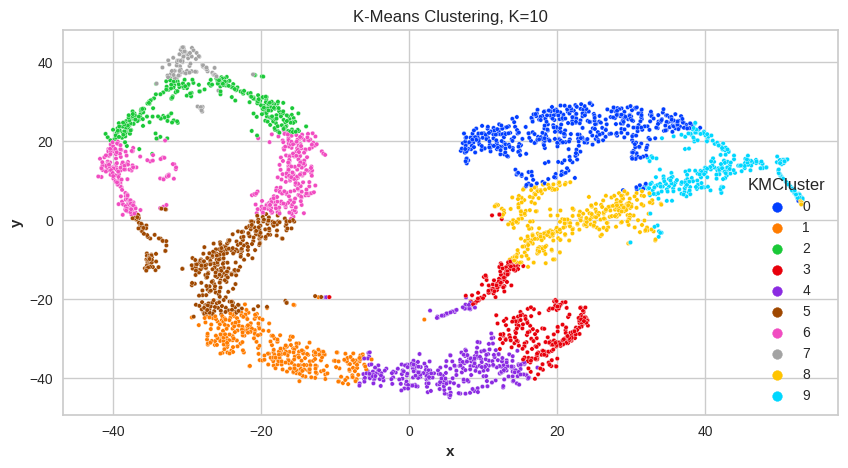

In [26]:
## Specify number of clusters you inferred from the above knee plots
Kdesired = 10

# Run K-Means Clustering to partition Gaia into the desired number of clusters, view
X_best['KMCluster'] = KMeans(n_clusters=Kdesired, init='k-means++', n_init=1, random_state=123).fit(flux).labels_
plt.rcParams['figure.figsize'] = (10,5)
sns.scatterplot(x='x', y='y', hue='KMCluster', data = X_best, s=10, palette="bright").set(title='K-Means Clustering, K=%d' % Kdesired);

# Supervised Learning with Gaia

Up until now we have attempted to learn about our Gaia data via unsupervised learning techniques. Using only the source spectra, we have created 2-d visualizations of Gaia and determined, via both visual inspection and formal clustering with K-Means, that there are likely some natural groupings within the data. These techniques are intended to help you explore high-dimensional data when you otherwise know nothing about it. We are just trying to answer questions like "what might be going on in my dataset?"

In some settings we are given **auxiliarly information** about our data, and are interested in building a model to **predict** this auxiliary info. about new (but similar) data that we may encounter in the future. This task is called Supervised Machine Learning. The "supervisor" is the auxiliary info we receive, which is generally called a **data label**.

## Gaia Labels of Variable Star Type

Each source in our Gaia dataset has auxiliary information associated with it which we have ignored up until now. This additional info is a label indicating the type of star each source likely is (i.e., its *class*), and was generated by a [previous  analyis of the Gaia archive](https://arxiv.org/abs/2211.17238).

Let's download our data labels, called class labels, and inspect them. To start, we'd like to know what types of stars are known to exist in our dataset, and how many of each type we have.


In [27]:
## Download Gaia labels
class_label = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/GaiaREU_class-name_trn.csv', header=None)[0]
# Ensure we have a label for each source
print(flux.shape)
print(class_label.shape)
# Produce a frequency table, listing the unique class names and the number of sources belonging to each
class_label.value_counts(sort=True)

(3388, 343)
(3388,)


YSO     1009
CEP      731
BCEP     533
SPB      474
EP       169
SYST     167
ACYG     139
WD        91
CV        62
AGN       13
Name: 0, dtype: int64

We can see that every source is labeled by an acronym (e.g., YSO). Let's fetch a list of acronym descriptions.

In [28]:
## Download class descriptions
class_desc = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/GaiaREU_class-description.csv', header=0)
class_desc

,class_name,class_description
0,YSO,Young Stellar Object.
1,CEP,"Cepheid variable types: delta Cepheid, anomalo..."
2,BCEP,Beta Cephei type variable.
3,SPB,Slowly Pulsating B-star variable.
4,EP,Star with exoplanet transits.
5,SYST,Symbiotic variable star.
6,ACYG,Alpha Cygni-type variable.
7,WD,White Dwarf variable stars of types: ZZ Ceti (...
8,CV,Cataclysmic variable.
9,AGN,Active Galactic Nuclei (including Quasars).


Since we already produced a low-d embedding of our data, let's project these labels onto it to see whether the known class labels correspond to any of the structure that t-SNE / UMAP picked out. Remember that neither t-SNE nor UMAP saw any of these labels during their learning phase.

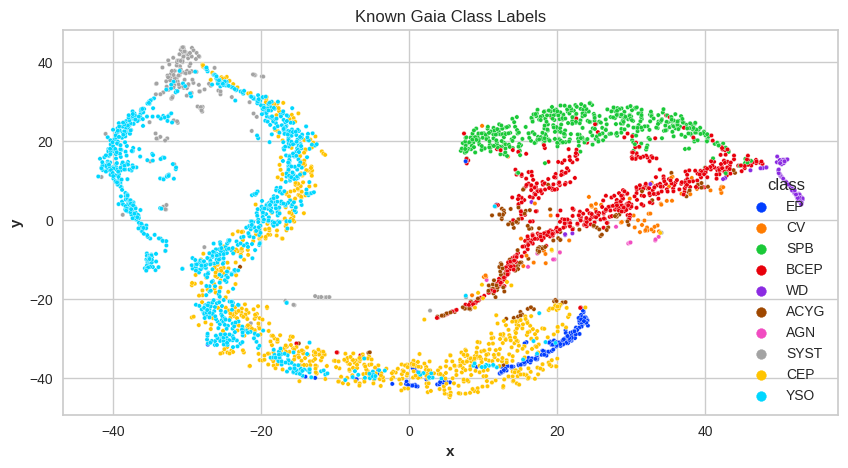

In [29]:
## Project known labels onto our favorite embedding
X_best['class'] = class_label
plt.rcParams['figure.figsize'] = (10,5)
sns.scatterplot(x='x', y='y', hue='class', data = X_best, s=10, palette="bright").set(title='Known Gaia Class Labels');

> **What do you see in the above?**

> **How do the known labels conform (or not) to the structure in our visualization?**

> **Do you think the position of each class on the embedding, relative to others, reveals anything about the spectral characteristics of each star type?**

## Classification with Neural Networks  

Given a data vector $x$ (e.g., one of our spectra) and its associated label $y$ (e.g., the star type associated the spectra), Supervised Learning algorithms  try to find a function $f(x)$, which is called the *model*, such that $y = f(x)$ is satisfied for as many $x$ in our dataset as possible. When $y$ is a categorical label (which is our setting), the process of finding an optimal $f$ is called ***classification***; when $y$ is numeric, it is known as ***regression***.

As with clustering, there are [many different classification algorithms](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html). Today, we will fit a [Multi Layer Perceptron](https://scikit-learn.org/stable/modules/neural_networks_supervised.html), also called a neural network. A MLP is a network of artificial nodes (neurons) that are arranged in a user-specified way to connect information in the data to that in the labels.  The process of forming these connections between artificial neurons is called ***neural learning***, or *model fitting*.  The number of neurons, and how they are arranged in the network, are the major parameters a user can control to influence the success of neural learning. Different network architectures give rise to different models from which we must select the best.

## Model Selection via Cross Validation

Once a model $f$ is fit, it can be used to make label predictions $y^* = f(x^*)$ on new (unseen) data $x^*$. In addition to predicting the label $y^*$ for new data, we are also interested in obtaining some idea of how right (or wrong) our predictions might be.  This is called ***uncertainty estimation***, and forms the basis for all statistics.

**K-Fold Cross validation** is one way of estimating this uncertainty. The "best" supervised learning model among a set of candidate models is then selected as the most accurate, when this uncertainty is incorporated.  Briefly, K-Fold CV involves:
1. Splitting our dataset into a training set and a test set.
2. The model is fit on the training data, and ...
3. used to predict the labels for the data in the test set.
4. We then measure the model's predictive accuracy on the test set, because we know the true labels associated with this set.  
5. This process is repeated $K$ times, and we infer uncertainty about predictions based on the range of accuracies we observe during the process.

Note that in each round of the above, the test data does not influence the model fitting process. This is what allows us to generalize how well our model performs in the real world.

## Building a Gaia Classifier

Let's specify two different network architectures to learn a predictive model for Gaia. One will be a MLP with 1 hidden layer of 100 neurons, and the other will be a MLP with a hidden layer of 10 neurons. The neurons which are doing the learning are called the network's ***hidden neurons***. We will perform 5-Fold Cross Validation in order to select between the two competing architectures.  

There is a lot going on here, but it is relatively easy to accomplish with just a few scikit-learn functions. *Note that the following cell may take a few minutes to run.*

In [35]:
## Define model100, with 100 neurons in a single hidden layer
model100 = MLPClassifier(hidden_layer_sizes=100, verbose=False, warm_start=True, max_iter=500, tol = 1e-3)
## Define model10, with 10 neurons in a single hidden layer
model20x5 = MLPClassifier(hidden_layer_sizes=10, verbose=False, warm_start=True, max_iter=500, tol = 1e-3)

## scikit-learn's cross_validate function takes a model and a # of CV Folds, and does all of the splitting / training / scoring / repeating internally.
#  Here, we tell cross_validate to use prediction accuracy as the scoring method
CV_Folds = 5

CV100_results = cross_validate(model100, X=flux, y=class_label, cv=CV_Folds, return_train_score=True, scoring='balanced_accuracy', verbose=2, n_jobs=5)
CV10_results = cross_validate(model10, X=flux, y=class_label, cv=CV_Folds, return_train_score=True, scoring='balanced_accuracy', verbose=2, n_jobs=5)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.5s remaining:   45.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   35.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   35.1s finished


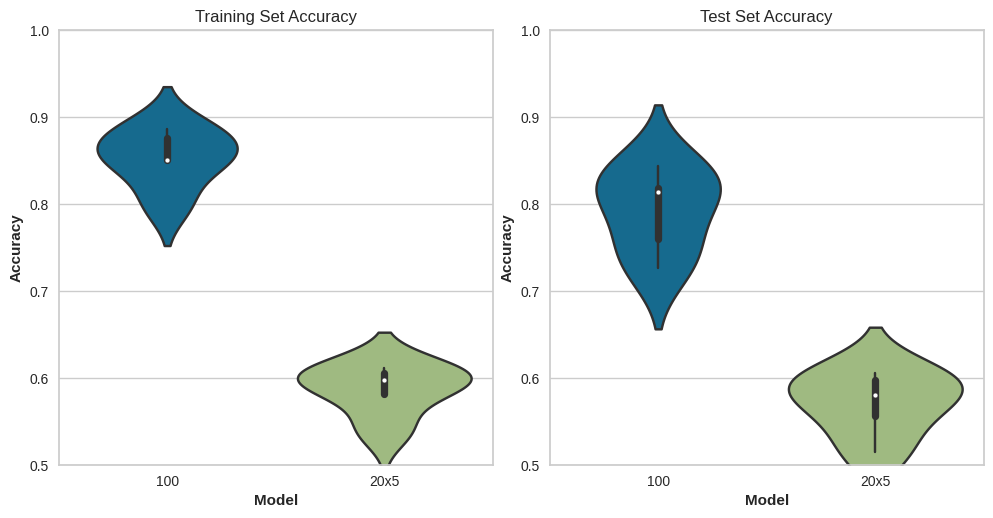

In [36]:
## Visualize the CV results.
#  First combine both model results into one data frame for seaborn plotting
cv100df = pd.DataFrame(CV100_results)
cv100df.insert(0, 'model', '100 Neurons')
cv10df = pd.DataFrame(CV10_results)
cv10df.insert(0, 'model', '10 Neurons')

cvdf = pd.concat([cv100df, cv10df])

#  Plot
plt.rcParams['figure.figsize'] = (10,5)
fig, axes = plt.subplots(1, 2)
fig.tight_layout()
sns.violinplot(data=cvdf, x="model", y="train_score", ax=axes[0]).set(title='Training Set Accuracy', ylabel='Accuracy', xlabel='Model');
axes[0].set_ylim([0.5,1.0]);
sns.violinplot(data=cvdf, x="model", y="test_score", ax=axes[1]).set(title='Test Set Accuracy', ylabel='Accuracy', xlabel='Model');
axes[1].set_ylim([0.5,1.0]);

Above, we have plotted the distribution of accuracies resulting from 5-fold CV of both models on the training and test sets.
> **Why should we only make model selection decisions based on performance on the test set?**

Notice that accuracy on the training set is higher than on the test set, which is expected behavior for a well-fit model.
> **Can you think why this is the case?**

> **Based on the above comparisons, which neural network architecture is more accurate? Store your decisions in the variable best_arch below.**


In [37]:
## Uncomment the line below that corresponds to the more accurate model
best_arch = 100
#best_arch = 10

**Cross validation is performed solely for model selection purposes.** Once a  model has been selected via CV, we must re-fit it using all available data for training. This gives us the most informed model from which we can make predictions about new data in the future.  Below we re-fit, using the `best_arch` specified above.

In [38]:
## Refit MLP with all data, using selected architecture
best_model = MLPClassifier(hidden_layer_sizes=best_arch, verbose=True, max_iter=500, tol = 1e-3)
best_model.fit(flux, class_label)

Iteration 1, loss = 2.09067317
Iteration 2, loss = 1.68433121
Iteration 3, loss = 1.42463718
Iteration 4, loss = 1.28180285
Iteration 5, loss = 1.19595239
Iteration 6, loss = 1.13903571
Iteration 7, loss = 1.09802695
Iteration 8, loss = 1.06715725
Iteration 9, loss = 1.04106456
Iteration 10, loss = 1.01972975
Iteration 11, loss = 0.99885273
Iteration 12, loss = 0.97805918
Iteration 13, loss = 0.96127646
Iteration 14, loss = 0.94458133
Iteration 15, loss = 0.92997629
Iteration 16, loss = 0.91545747
Iteration 17, loss = 0.90255236
Iteration 18, loss = 0.88920023
Iteration 19, loss = 0.87570920
Iteration 20, loss = 0.86355990
Iteration 21, loss = 0.85234929
Iteration 22, loss = 0.84154746
Iteration 23, loss = 0.83161672
Iteration 24, loss = 0.82214673
Iteration 25, loss = 0.81193521
Iteration 26, loss = 0.80400074
Iteration 27, loss = 0.79460077
Iteration 28, loss = 0.78948350
Iteration 29, loss = 0.77984769
Iteration 30, loss = 0.77296222
Iteration 31, loss = 0.76657690
Iteration 32, los

MLPClassifier(hidden_layer_sizes=100, max_iter=500, tol=0.001, verbose=True)

## Predicting Labels for New Gaia Sources

Breaking news! An update to the Gaia archive contains spectra for several new sources, and we are asked to predict the labels for these new sources based on the classification model we just built. `scikit-learn` makes this relatively easy.

Let's fetch & inspect the new data.

In [39]:
## Download & inspect new data
new_flux = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/GaiaREU_flux_tst.csv', header=None)
print(new_flux.shape)
print(new_flux.iloc[0])

(593, 343)
0      0.157631
1      0.140994
2      0.124082
3      0.120104
4      0.125592
         ...   
338    0.004656
339    0.004211
340    0.004113
341    0.004181
342    0.004694
Name: 0, Length: 343, dtype: float64


With a previously fit model in hand, we can easily obtain the predicted labels for these new data

In [40]:
## Predict class labels for new data using best_model
new_flux_predicted_label = best_model.predict(new_flux)
pd.Series(new_flux_predicted_label).value_counts()

YSO     189
CEP     116
BCEP     95
SPB      88
SYST     31
EP       30
ACYG     18
WD       15
CV       11
dtype: int64

Suppose we also have access to ground truth labels for these new data which were produced via careful analysis by the astronomy community. We would like to see how well our predictions match these true labels. First, we download and inspect the true labels

In [41]:
# Download true labels for the new data
new_flux_class_label = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/GaiaREU_class-name_tst.csv', header=None)[0]
print(new_flux_class_label.value_counts())

YSO     177
CEP     129
BCEP     94
SPB      83
EP       29
SYST     29
ACYG     24
WD       16
CV       10
AGN       2
Name: 0, dtype: int64


Next, we compute the overall accuracy of our predictions (the proportion of new sources we correctly classified):

In [42]:
## Compute overall accuracy of our predictions
acc = balanced_accuracy_score(y_true = new_flux_class_label, y_pred = new_flux_predicted_label).round(2)
print('Overall Predictive Accuracy: %.2f' % acc)

Overall Predictive Accuracy: 0.80


The point of all of the cross-validating we did earlier was to estimate how our model would perform when classifying new data.
> **Does the accuracy we achieved seem reasonable when compared to the distribution of CV test set accuracies we computed and visualized above?**  

When we do not achieve 100% accuracy in classification tasks, we are usually asked to explain why. A [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) helps identify weaknesses in your classifier. Confusion matrices are tables whose $(i,j)$ entry contains the count of observations whose true label is $i$, but whose predicted label is $j$. Often, these counts are normalized with respect to the total number of observations whose true label is $i$, such that the rowsums of the table = 1.

Let's compute and visualize a confusion matrix for the predictions we just made for the new Gaia fluxes.

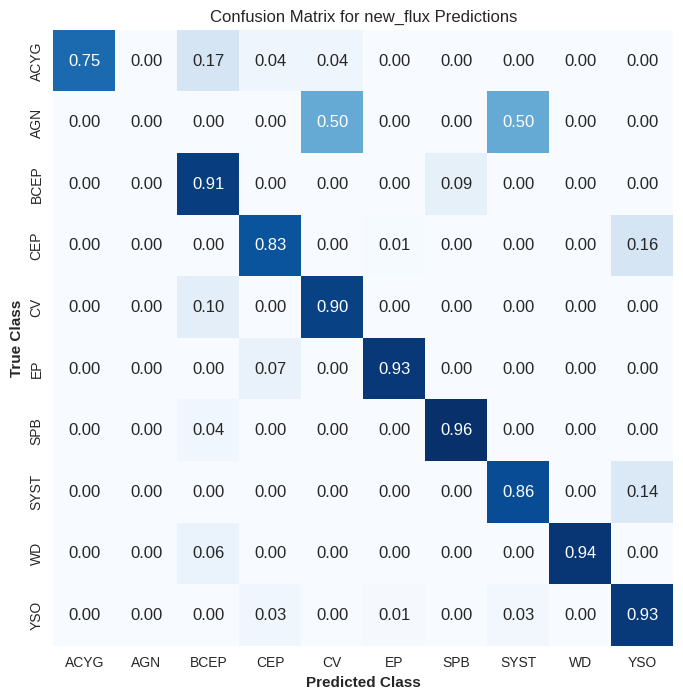

In [43]:
# Make confusion matrix, convert to data frame for plotting
cfmat = confusion_matrix(y_true = new_flux_class_label, y_pred = new_flux_predicted_label, labels=best_model.classes_, normalize='true')
cfmat = pd.DataFrame(cfmat, columns=best_model.classes_, index=best_model.classes_)

# Visualize
plt.rcParams['figure.figsize'] = (8,8)
sns.heatmap(cfmat, cmap = 'Blues', annot=True, fmt='.2f', cbar=False).set(title='Confusion Matrix for new_flux Predictions', xlabel = 'Predicted Class', ylabel = 'True Class');

Examining a confusion matrix immediately tells you which classes your classifier is having trouble predicting, if any. Given its special structure, ideally we want the diagonal entries of the matrix to = 1, and all off-diagonal entries = 0.

> **Based on the confusion matrix you just made, which classes does your model predict well? Which does it predict poorly?**

Now that we have an idea *where* (for what classes) our classifier is performing well / poorly we can dig a little deeper into our data to explain *why* that might be the case.

Below, we visualize the class-wise flux statistics (the class-wise mean $\pm$ 1 standard deviation) of our training data.  

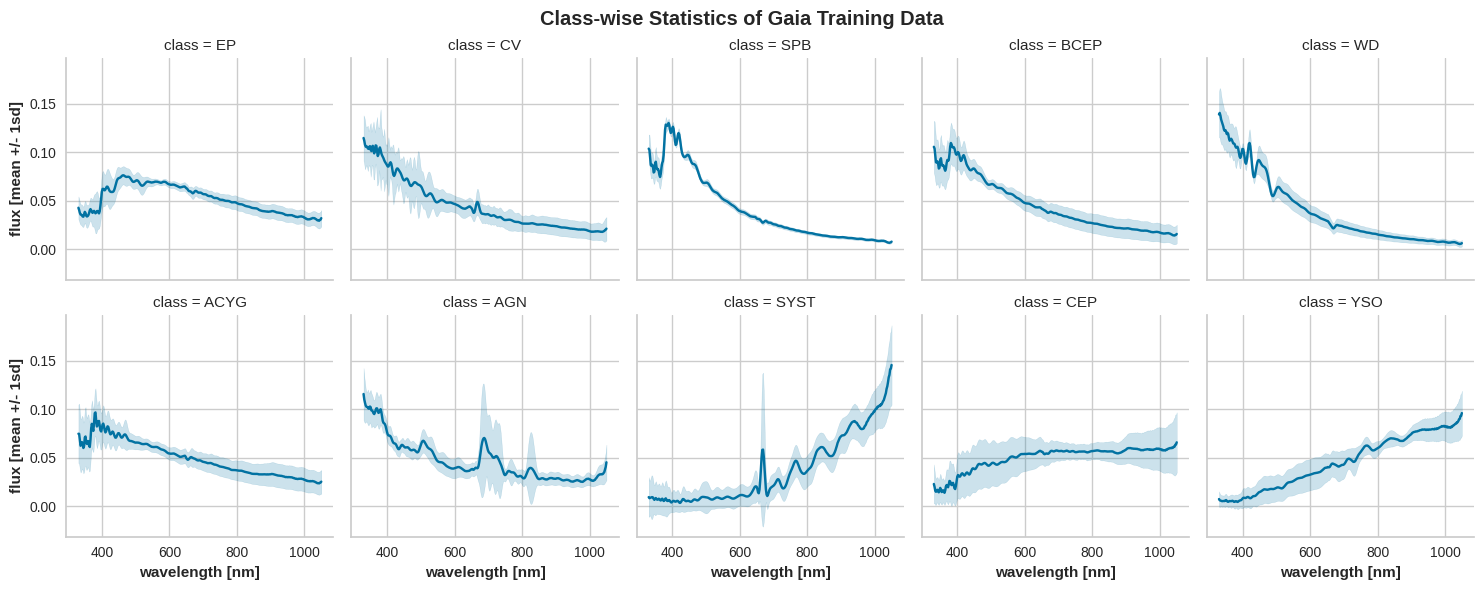

In [46]:
# Add the class information to our flux data frame, convert from wide to long format for plotting
clstatdf = pd.melt(pd.concat([flux, pd.Series(class_label, name='class')], axis=1), id_vars='class', var_name="wvl", value_name='flux')

# Seaborn Faceting makes group-wise summaries easy to visualize
plt_clstat = sns.FacetGrid(clstatdf, col='class', col_wrap=5)
plt_clstat.map(sns.lineplot, "wvl", "flux", errorbar=('sd',1)).set(ylabel = 'flux [mean +/- 1sd]', xlabel='wavelength [nm]');
plt_clstat.fig.subplots_adjust(top=0.9);
plt_clstat.fig.suptitle('Class-wise Statistics of Gaia Training Data');

Based on the confusion matrix and class-wise statistics summaries, answer the following questions:
1. **How do the spectra for the classes you predicted well compare to others? Do they look similar / different?**
2. **How do the spectra for the classes you predicted poorly compare to others?**
3. **Based on the class-wise spectral profiles, could you have guessed which classes would be easy / hard to predict?**
4. **AGNs appear hard to predict correctly. Can you guess why? Hint: Consider how many AGNs were used to train your model.**